# Task 2. Experimental Evaluation of NLP Pipelines

https://www.kaggle.com/datasets/naseralqaydeh/named-entity-recognition-ner-corpus

In [ ]:
# Download spaCy English model
!python -m spacy download en_core_web_sm

# Import libraries
import spacy
import pandas as pd
from sklearn.metrics import classification_report

# Load dataset
df = pd.read_csv("ner.csv")
df.head()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 54.5 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


,Sentence #,Sentence,POS,Tag
0,Sentence: 1,Thousands of demonstrators have marched throug...,"['NNS', 'IN', 'NNS', 'VBP', 'VBN', 'IN', 'NNP'...","['O', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', '..."
1,Sentence: 2,Families of soldiers killed in the conflict jo...,"['NNS', 'IN', 'NNS', 'VBN', 'IN', 'DT', 'NN', ...","['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', ..."
2,Sentence: 3,They marched from the Houses of Parliament to ...,"['PRP', 'VBD', 'IN', 'DT', 'NNS', 'IN', 'NN', ...","['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', ..."
3,Sentence: 4,"Police put the number of marchers at 10,000 wh...","['NNS', 'VBD', 'DT', 'NN', 'IN', 'NNS', 'IN', ...","['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', ..."
4,Sentence: 5,The protest comes on the eve of the annual con...,"['DT', 'NN', 'VBZ', 'IN', 'DT', 'NN', 'IN', 'D...","['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', ..."


### Classical NLP using tokenization, stemming, POS tagging (Spacy)

In [16]:
import spacy
from nltk.stem import PorterStemmer
from sklearn.metrics import classification_report

# Initialize spaCy and stemmer
nlp = spacy.load("en_core_web_sm")
stemmer = PorterStemmer()

true_labels = []
pred_labels_classical = []

for i, row in df.iterrows():
    sentence = row['Sentence']
    tokens = eval(row['POS'])
    tags = eval(row['Tag'])

    true_labels.extend(tags)

    # Initialize predictions as 'O'
    pred = ['O'] * len(tokens)

    # Process sentence
    doc = nlp(sentence)

    # Classical NLP steps: tokenization, POS tagging, stemming
    for idx, token in enumerate(doc):
        stem = stemmer.stem(token.text)
        pos = token.pos_


    # Map spaCy detected entities
    for ent in doc.ents:
        # Find index of first matching token in dataset tokens
        for idx, tok in enumerate(tokens):
            if ent.text.startswith(tok):
                pred[idx] = 'B-' + ent.label_
                # If entity spans multiple tokens, mark as I-
                ent_words = ent.text.split()
                for j in range(1, len(ent_words)):
                    if idx+j < len(pred):
                        pred[idx+j] = 'I-' + ent.label_
                break

    pred_labels_classical.extend(pred)

# Evaluate
print("Classical NLP Performance:")
print(classification_report(true_labels, pred_labels_classical, zero_division=0))


Classical NLP Performance:
              precision    recall  f1-score   support

     B-MONEY       0.00      0.00      0.00         0
       B-ORG       0.00      0.00      0.00         0
       B-art       0.00      0.00      0.00       402
       B-eve       0.00      0.00      0.00       308
       B-geo       0.00      0.00      0.00     37644
       B-gpe       0.00      0.00      0.00     15870
       B-nat       0.00      0.00      0.00       201
       B-org       0.00      0.00      0.00     20143
       B-per       0.00      0.00      0.00     16990
       B-tim       0.00      0.00      0.00     20333
     I-MONEY       0.00      0.00      0.00         0
       I-art       0.00      0.00      0.00       297
       I-eve       0.00      0.00      0.00       253
       I-geo       0.00      0.00      0.00      7414
       I-gpe       0.00      0.00      0.00       198
       I-nat       0.00      0.00      0.00        51
       I-org       0.00      0.00      0.00     16784


### Transformer-based pipeline using a pre-trained model (BERT)

In [19]:
from transformers import AutoTokenizer, AutoModelForTokenClassification, pipeline
from sklearn.metrics import classification_report
import pandas as pd

# Initialize BERT tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("dbmdz/bert-large-cased-finetuned-conll03-english")
model = AutoModelForTokenClassification.from_pretrained("dbmdz/bert-large-cased-finetuned-conll03-english")

# NER pipeline
ner_pipe = pipeline("ner", model=model, tokenizer=tokenizer, aggregation_strategy="simple")

pred_labels_bert = []
true_labels = []

for i, row in df.iterrows():
    sentence = row['Sentence']
    tokens = eval(row['POS'])
    tags = eval(row['Tag'])

    true_labels.extend(tags)

    # Predict with BERT
    ner_results = ner_pipe(sentence)

    # Initialize prediction list as 'O'
    pred = ['O'] * len(tokens)

    # Map BERT entity spans to dataset tokens
    for ent in ner_results:
        char_idx = 0
        start_token_idx = None
        end_token_idx = None
        for idx, tok in enumerate(tokens):
            token_len = len(tok)
            if char_idx <= ent['start'] < char_idx + token_len:
                start_token_idx = idx
            if char_idx < ent['end'] <= char_idx + token_len:
                end_token_idx = idx
            char_idx += token_len + 1  # +1 for space

        if start_token_idx is not None and end_token_idx is not None:
            pred[start_token_idx] = 'B-' + ent['entity_group']
            for j in range(start_token_idx+1, end_token_idx+1):
                pred[j] = 'I-' + ent['entity_group']

    pred_labels_bert.extend(pred)

# Evaluate
print("Transformer-based BERT Performance:")
print(classification_report(true_labels, pred_labels_bert, zero_division=0))


Some weights of the model checkpoint at dbmdz/bert-large-cased-finetuned-conll03-english were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu

Transformer-based BERT Performance:
               precision    recall  f1-score   support

        B-art       0.78      0.72      0.75       402
        B-eve       0.81      0.76      0.78       308
        B-geo       0.92      0.89      0.91     37644
        B-gpe       0.88    

# -------------- Task 5: Independent Mini Project: Real-World Application Challenge-----------------

https://www.kaggle.com/datasets/anjaneyatripathi/emotion-classification-nlp?select=emotion-labels-train.csv

In [ ]:
import pandas as pd

# load data
train = pd.read_csv("emotion-labels-train.csv")
val   = pd.read_csv("emotion-labels-val.csv")
test  = pd.read_csv("emotion-labels-test.csv")

In [ ]:
# check null values
print("Train set nulls:\n", train.isnull().sum())
print("\nValidation set nulls:\n", val.isnull().sum())
print("\nTest set nulls:\n", test.isnull().sum())

Train set nulls:
 text     0
label    0
dtype: int64

Validation set nulls:
 text     0
label    0
dtype: int64

Test set nulls:
 text     0
label    0
dtype: int64


### Design and implement Classical NLP using tokenization, stemming, POS tagging (Spacy)

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# TF-IDF Vectorization (fit on train, transform on val/test)
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X_train_vect = vectorizer.fit_transform(train["text"])
X_val_vect   = vectorizer.transform(val["text"])
X_test_vect  = vectorizer.transform(test["text"])

y_train = train["label"]
y_val   = val["label"]
y_test  = test["label"]

# Logistic Regression model
clf = LogisticRegression(max_iter=1000, class_weight="balanced")
clf.fit(X_train_vect, y_train)


LogisticRegression(class_weight='balanced', max_iter=1000)

### Evaluate Logistic Regression of NLP Pipeline

In [ ]:
# Predictions on validation and test sets
y_val_pred  = clf.predict(X_val_vect)
y_test_pred = clf.predict(X_test_vect)

# Evaluation - Validation
print("Validation Accuracy:", accuracy_score(y_val, y_val_pred))
print("\nValidation Classification Report:\n", classification_report(y_val, y_val_pred))

# Evaluation - Test
print("Test Accuracy:", accuracy_score(y_test, y_test_pred))
print("\nTest Classification Report:\n", classification_report(y_test, y_test_pred))


Validation Accuracy: 0.7867435158501441

Validation Classification Report:
               precision    recall  f1-score   support

       anger       0.80      0.79      0.80        84
        fear       0.81      0.78      0.80       110
         joy       0.86      0.77      0.81        79
     sadness       0.68      0.81      0.74        74

    accuracy                           0.79       347
   macro avg       0.79      0.79      0.79       347
weighted avg       0.79      0.79      0.79       347

Test Accuracy: 0.7686187141947803

Test Classification Report:
               precision    recall  f1-score   support

       anger       0.78      0.75      0.76       760
        fear       0.78      0.75      0.77       995
         joy       0.83      0.82      0.83       714
     sadness       0.68      0.76      0.72       673

    accuracy                           0.77      3142
   macro avg       0.77      0.77      0.77      3142
weighted avg       0.77      0.77      0.77  

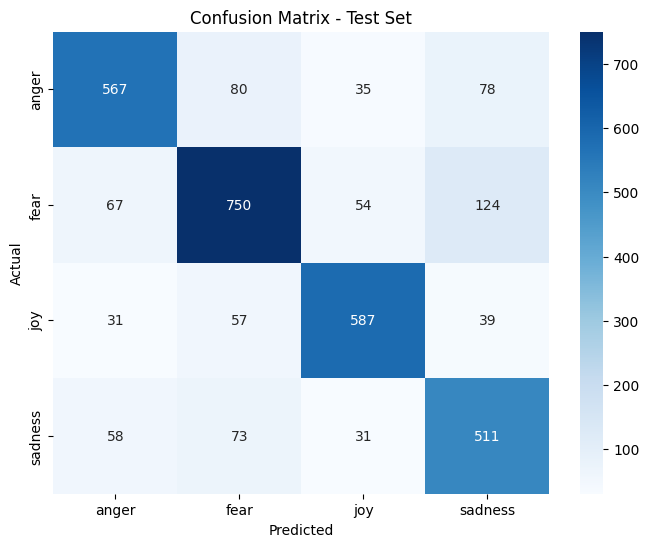

In [ ]:
# Confusion Matrix - Test
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=clf.classes_, yticklabels=clf.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Test Set")
plt.show()

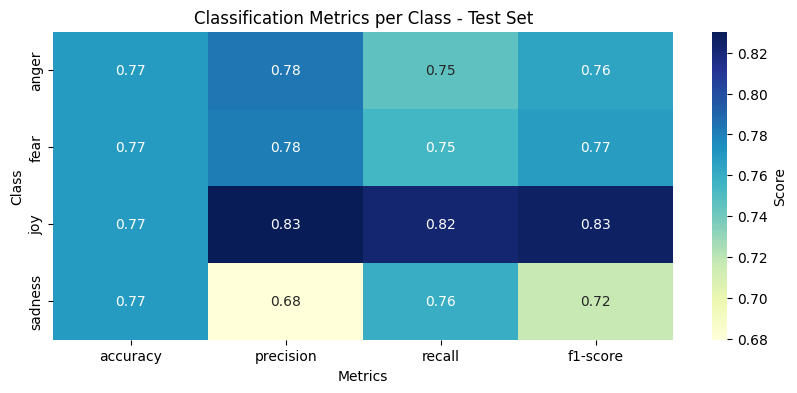

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, accuracy_score

# Overall accuracy
accuracy = accuracy_score(y_test, y_test_pred)

# Generate classification report as dict
report_dict = classification_report(y_test, y_test_pred, output_dict=True)

# Convert to DataFrame
report_df = pd.DataFrame(report_dict).transpose()

# Keep only precision, recall, f1-score (exclude support)
metrics_df = report_df[['precision', 'recall', 'f1-score']].iloc[:-3]  # classes only

# Add accuracy column (same for all classes)
metrics_df['accuracy'] = accuracy

# Reorder columns if desired
metrics_df = metrics_df[['accuracy', 'precision', 'recall', 'f1-score']]

# Plot heatmap
plt.figure(figsize=(10, len(metrics_df)*0.5 + 2))  # adjust height by number of classes
sns.heatmap(metrics_df.astype(float), annot=True, cmap="YlGnBu", fmt=".2f", cbar_kws={'label': 'Score'})
plt.title("Classification Metrics per Class - Test Set")
plt.ylabel("Class")
plt.xlabel("Metrics")
plt.show()


### Design and implementTransformer-based pipeline using a pre-trained model DistilBERT

In [ ]:
import pandas as pd
from transformers import DistilBertTokenizerFast, TFDistilBertForSequenceClassification
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf

# Encode labels
le = LabelEncoder()
train["label_enc"] = le.fit_transform(train["label"])
val["label_enc"]   = le.transform(val["label"])
test["label_enc"]  = le.transform(test["label"])

# Tokenizer
tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")

# Tokenize datasets
def tokenize(batch):
    return tokenizer(batch["text"].tolist(), truncation=True, padding=True)

X_train = tokenize(train)
X_val   = tokenize(val)
X_test  = tokenize(test)

# Convert to tf.data.Dataset
def make_dataset(encodings, labels, batch_size=16, shuffle=False):
    dataset = tf.data.Dataset.from_tensor_slices((dict(encodings), labels))
    if shuffle:
        dataset = dataset.shuffle(10000)
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

train_dataset = make_dataset(X_train, train["label_enc"].values, batch_size=16, shuffle=True)
val_dataset   = make_dataset(X_val, val["label_enc"].values, batch_size=16)
test_dataset  = make_dataset(X_test, test["label_enc"].values, batch_size=16)

# Load DistilBERT model for sequence classification
model = TFDistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=len(le.classes_),
    from_pt=True
)

# Compile model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"]
)

# Train model
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=4
)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/268M [00:00<?, ?B/s]

TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_projector.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSeq

Epoch 1/4
226/226 [==============================] - 1380s 6s/step - loss: 0.7731 - accuracy: 0.6803 - val_loss: 0.3931 - val_accuracy: 0.8588
Epoch 2/4
226/226 [==============================] - 1349s 6s/step - loss: 0.2993 - accuracy: 0.9006 - val_loss: 0.4101 - val_accuracy: 0.8732
Epoch 3/4
226/226 [==============================] - 1362s 6s/step - loss: 0.1783 - accuracy: 0.9380 - val_loss: 0.4627 - val_accuracy: 0.8559
Epoch 4/4
226/226 [==============================] - 1365s 6s/step - loss: 0.1129 - accuracy: 0.9613 - val_loss: 0.4680 - val_accuracy: 0.8674


### Evaluate the performance

In [ ]:
import numpy as np
from sklearn.metrics import classification_report, accuracy_score

# Build test dataset
test_dataset = make_dataset(X_test, test["label_enc"].values, batch_size=16)

# Predictions
preds = model.predict(test_dataset)
y_pred = np.argmax(preds["logits"], axis=1)

# Evaluation
print("Test Accuracy:", accuracy_score(test["label_enc"], y_pred))
print("\nClassification Report (Test):\n",
      classification_report(test["label_enc"], y_pred, target_names=le.classes_))


197/197 [==============================] - 423s 2s/step
Test Accuracy: 0.8599618077657543

Classification Report (Test):
               precision    recall  f1-score   support

       anger       0.87      0.85      0.86       760
        fear       0.87      0.83      0.85       995
         joy       0.91      0.90      0.90       714
     sadness       0.79      0.88      0.83       673

    accuracy                           0.86      3142
   macro avg       0.86      0.86      0.86      3142
weighted avg       0.86      0.86      0.86      3142



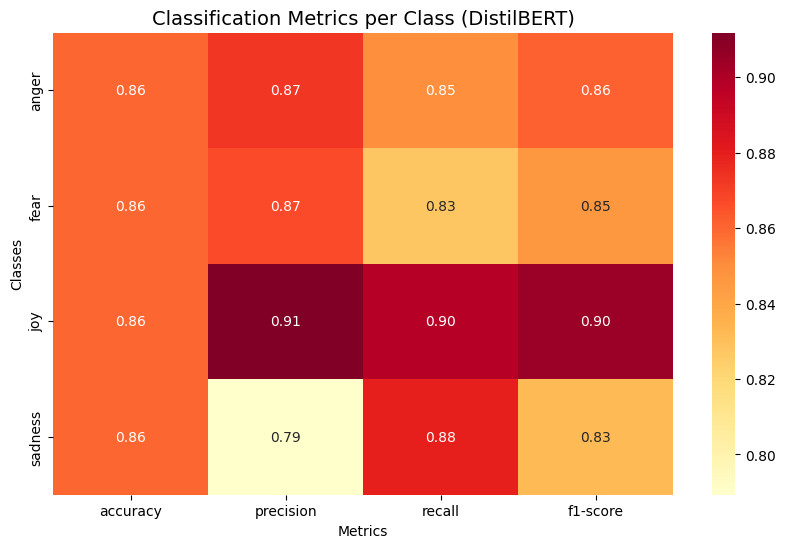

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, accuracy_score

# Compute classification report as dict
report_dict = classification_report(
    test["label_enc"],
    y_pred,
    output_dict=True,
    target_names=le.classes_
)

# Convert to DataFrame
report_df = pd.DataFrame(report_dict).transpose()

# Keep only per-class rows
report_df = report_df.loc[le.classes_, ['precision', 'recall', 'f1-score']]

# Add overall accuracy column (same for all classes)
overall_acc = accuracy_score(test["label_enc"], y_pred)
report_df['accuracy'] = overall_acc

# Reorder columns: acc, prec, recall, f1
report_df = report_df[['accuracy', 'precision', 'recall', 'f1-score']]

# Plot heatmap
plt.figure(figsize=(10,6))
sns.heatmap(report_df, annot=True, cmap="YlOrRd", fmt=".2f", cbar=True)

plt.title("Classification Metrics per Class (DistilBERT)", fontsize=14)
plt.xlabel("Metrics")
plt.ylabel("Classes")
plt.show()


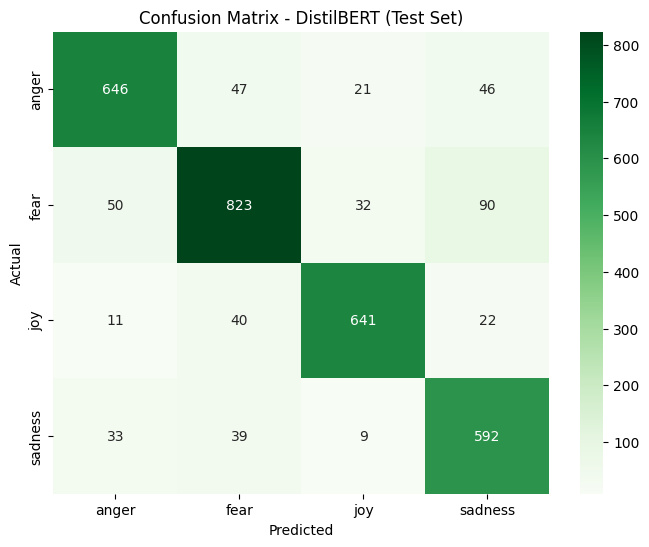

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Confusion Matrix - Test
cm = confusion_matrix(test["label_enc"], y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Greens",
            xticklabels=le.classes_,  # class names
            yticklabels=le.classes_)

plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - DistilBERT (Test Set)")
plt.show()

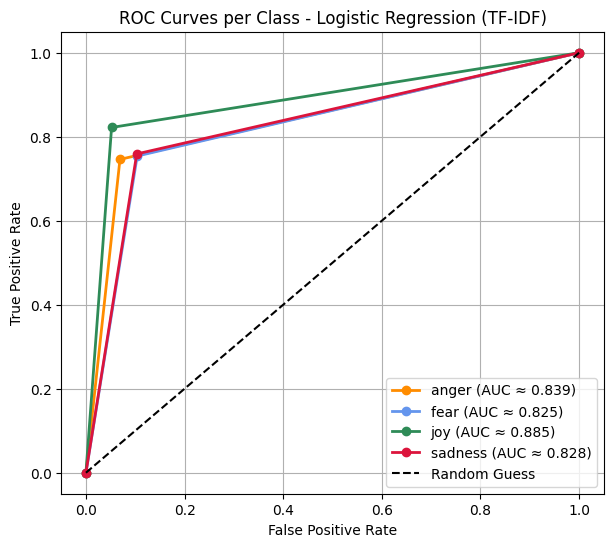

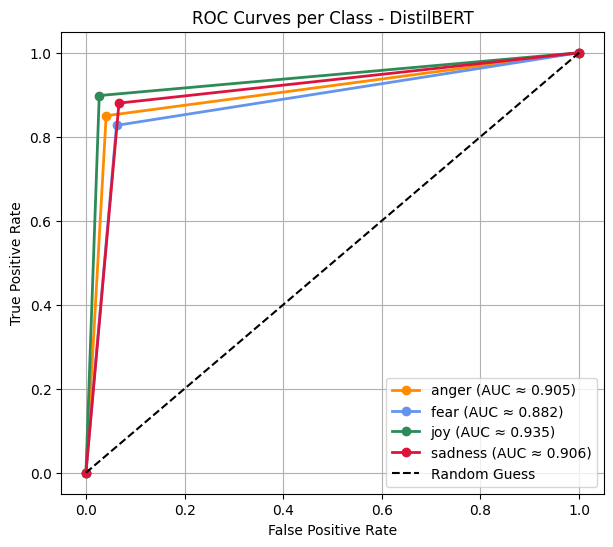

In [24]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import label_binarize
import numpy as np

# Prepare test labels
y_test_bin = label_binarize(y_test, classes=clf.classes_)   # for Logistic Regression
classes = clf.classes_

# Logistic Regression Probabilities
y_test_proba_logreg = clf.predict_proba(X_test_vect)

# DistilBERT Probabilities (apply softmax to logits)
from scipy.special import softmax
y_test_proba_distil = softmax(preds["logits"], axis=1)

# Compute ROC curve & AUC for each model
fpr_logreg, tpr_logreg, _ = roc_curve(y_test_bin.ravel(), y_test_proba_logreg.ravel())
auc_logreg = auc(fpr_logreg, tpr_logreg)

fpr_distil, tpr_distil, _ = roc_curve(y_test_bin.ravel(), y_test_proba_distil.ravel())
auc_distil = auc(fpr_distil, tpr_distil)

# Plot ROC curves
plt.figure(figsize=(7,6))

plt.plot(fpr_logreg, tpr_logreg, color="blue", lw=2,
         label=f"Logistic Regression (TF-IDF)")

plt.plot(fpr_distil, tpr_distil, color="red", lw=2,
         label=f"DistilBERT")

# Baseline
plt.plot([0,1], [0,1], "k--", lw=1.5, label="Random Guess")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves per Class")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


# -----------Task 4: Word Representations for Semantic Reasoning ----------------

https://www.kaggle.com/datasets/arhamrumi/amazon-product-reviews

In [ ]:
import pandas as pd
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess

# Load dataset
df = pd.read_csv("Reviews.csv")

df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


### Train your own Word2Vec model

In [ ]:
# Tokenize review texts
sentences = df['Text'].dropna().apply(lambda x: simple_preprocess(x))

# Train Word2Vec
model = Word2Vec(sentences, vector_size=100, window=5, min_count=5, workers=4)
model.save("amazon_word2vec.model")

### Analyze semantic similarity

In [ ]:
# Example: similarity between words
word1, word2 = "dog", "cat"

similarity = model.wv.similarity(word1, word2)
print(f"Cosine similarity between '{word1}' and '{word2}': {similarity:.3f}")

# Find most similar words
print(model.wv.most_similar("quality", topn=5))

Cosine similarity between 'dog' and 'cat': 0.900
[('probability', 0.6197999715805054), ('guality', 0.6156503558158875), ('quailty', 0.6010100245475769), ('octane', 0.5925118923187256), ('concentrations', 0.5920567512512207)]


### Design a mini experiment Clustering to test

In [ ]:
from sklearn.cluster import KMeans
import numpy as np

# Select some words from vocab
words = ['dog','cat','food','good','bad','taste','love','hate','price','quality']
vectors = np.array([model.wv[w] for w in words])

# KMeans clustering
kmeans = KMeans(n_clusters=4, random_state=0).fit(vectors)
for w, label in zip(words, kmeans.labels_):
    print(f"{w}: Cluster {label}")


dog: Cluster 2
cat: Cluster 2
food: Cluster 2
good: Cluster 1
bad: Cluster 1
taste: Cluster 0
love: Cluster 1
hate: Cluster 1
price: Cluster 3
quality: Cluster 3


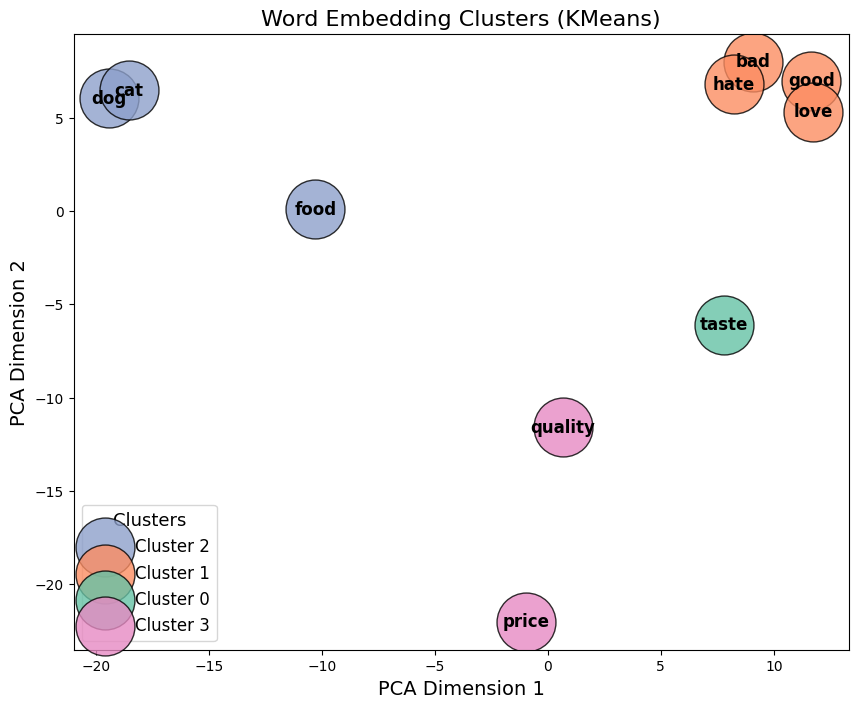

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
import pandas as pd

# PCA reduce
pca = PCA(n_components=2)
reduced = pca.fit_transform(vectors)

df_plot = pd.DataFrame({
    "word": words,
    "x": reduced[:,0],
    "y": reduced[:,1],
    "cluster": kmeans.labels_
})

# Get a palette for clusters
palette = sns.color_palette("Set2", n_colors=len(df_plot["cluster"].unique()))

plt.figure(figsize=(10,8))

# Plot per cluster so legend works
for cluster_id in df_plot["cluster"].unique():
    cluster_data = df_plot[df_plot["cluster"] == cluster_id]
    plt.scatter(cluster_data["x"], cluster_data["y"],
                s=1800,
                color=palette[cluster_id],
                edgecolor="k", alpha=0.8,
                label=f"Cluster {cluster_id}")   # 👈 legend label

    # Annotate words inside circles
    for i, row in cluster_data.iterrows():
        plt.text(row.x, row.y, row.word,
                 ha="center", va="center", fontsize=12, weight="bold")

# Titles and labels
plt.title("Word Embedding Clusters (KMeans)", fontsize=16)
plt.xlabel("PCA Dimension 1", fontsize=14)
plt.ylabel("PCA Dimension 2", fontsize=14)

# Show legend
plt.legend(title="Clusters", fontsize=12, title_fontsize=13)

plt.show()

# Task 3. Responsible NLP Case Study

https://www.kaggle.com/competitions/nlp-getting-started/data?select=train.csv

In [ ]:
import re
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [ ]:
# training data with labels
train_df = pd.read_csv("train.csv")

In [ ]:
df = df[['text', 'target']].dropna()
def clean_text(s):
    s = s.lower()
    s = re.sub(r"http\S+|www\S+|https\S+", "", s)
    s = re.sub(r"@\w+", "", s)
    s = re.sub(r"[^a-z0-9\s#']", " ", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s
df['text'] = df['text'].astype(str).map(clean_text)

### Train-Test Split and Vectorize

In [ ]:
# Split

X_train, X_test, y_train, y_test = train_test_split(
    df['text'], df['target'], test_size=0.20, random_state=42, stratify=df['target']
)

In [ ]:
# Vectorize

vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf  = vectorizer.transform(X_test)

### Train and Evaluate Logistic regression

In [ ]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter=1000, class_weight='balanced')
model.fit(X_train_tfidf, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000)

In [ ]:
#  Evaluate
y_pred = model.predict(X_test_tfidf)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification report:\n", classification_report(y_test, y_pred))
print("\nConfusion matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.8154957321076822

Classification report:
               precision    recall  f1-score   support

           0       0.83      0.84      0.84       869
           1       0.79      0.78      0.78       654

    accuracy                           0.82      1523
   macro avg       0.81      0.81      0.81      1523
weighted avg       0.82      0.82      0.82      1523


Confusion matrix:
 [[733 136]
 [145 509]]


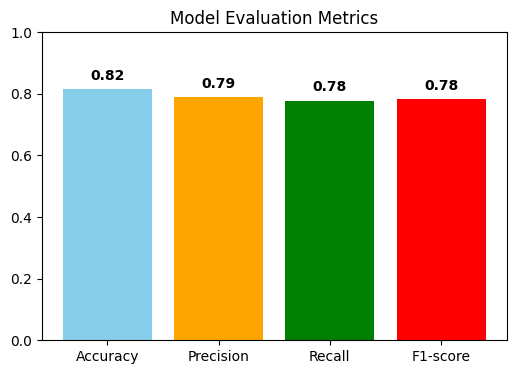

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_score, recall_score, f1_score

# --- Scores ---
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

scores = {
    "Accuracy": acc,
    "Precision": prec,
    "Recall": rec,
    "F1-score": f1
}

# --- Bar Plot ---
plt.figure(figsize=(6,4))
bars = plt.bar(scores.keys(), scores.values(), color=['skyblue','orange','green','red'])
plt.ylim(0,1)
plt.title("Model Evaluation Metrics")

# Add score labels above each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height+0.02, f"{height:.2f}",
             ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.show()

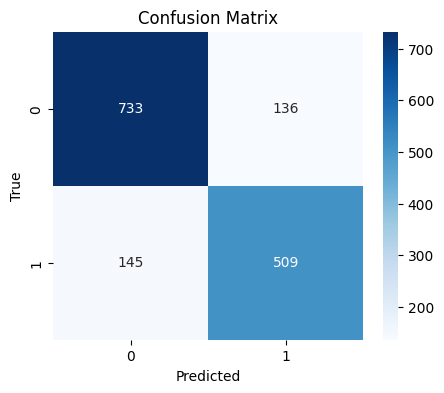

In [ ]:
# --- Confusion Matrix Heatmap ---
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[0,1], yticklabels=[0,1])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

### Save Misclassified Samples to check Hallucination and failure cases

In [ ]:
#  Save misclassified examples (with prediction probability)
probs = model.predict_proba(X_test_tfidf)  # shape (n_samples, 2)
pred_conf = probs.max(axis=1)
results = pd.DataFrame({
    'text': X_test.values,
    'true': y_test.values,
    'pred': y_pred,
    'pred_confidence': pred_conf
})
misclassified = results[results['true'] != results['pred']].sort_values('pred_confidence', ascending=False)
misclassified.to_csv("misclassified_examples.csv", index=False)
print(f"\nSaved {len(misclassified)} misclassified examples to misclassified_examples.csv")
print("Top 5 confident wrong predictions:")
print(misclassified.head(5))


Saved 281 misclassified examples to misclassified_examples.csv
Top 5 confident wrong predictions:
                                                   text  true  pred  \
791   do you feel like you are sinking in low self i...     1     0   
990   i just watched emmerdale nd i don't know who m...     1     0   
1425  maid charged with stealing dh30000 from police...     0     1   
753   you don't know because you don't smoke the way...     1     0   
34                            slicker than an oil spill     0     1   

      pred_confidence  
791          0.913712  
990          0.884546  
1425         0.876621  
753          0.875691  
34           0.872766  


### Save keyword bias check

In [ ]:
# Quick keyword-based bias check
keywords = ['allah','pray','bomb','muslim','hurricane','earthquake','flood','fire','attack','refugee','kashmir']
bias_rows = []
full_X = df['text']
full_y = df['target']
for kw in keywords:
    mask = full_X.str.contains(r'\b'+re.escape(kw)+r'\b', case=False, na=False)
    subset = df[mask]
    if len(subset)==0:
        continue
    preds = model.predict(vectorizer.transform(subset['text']))
    bias_rows.append({
        'keyword': kw,
        'count': len(subset),
        'pred_disaster_rate': float(preds.mean()),
        'true_disaster_rate': float(subset['target'].mean())
    })
bias_df = pd.DataFrame(bias_rows).sort_values('count', ascending=False)
bias_df.to_csv("keyword_bias_check.csv", index=False)
print("\nSaved keyword bias check to keyword_bias_check.csv")
print(bias_df)


Saved keyword bias check to keyword_bias_check.csv
       keyword  count  pred_disaster_rate  true_disaster_rate
7         fire    233            0.682403            0.708155
2         bomb    103            0.747573            0.728155
8       attack     95            0.736842            0.694737
6        flood     58            0.637931            0.672414
5   earthquake     44            0.886364            0.886364
4    hurricane     38            0.736842            0.657895
1         pray     13            0.230769            0.384615
0        allah      9            0.444444            0.666667
3       muslim      5            1.000000            1.000000
9      refugee      4            0.750000            1.000000
10     kashmir      2            1.000000            1.000000
